# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


# Objective:
### Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2)

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

</b>




### Task Performed: 

<br>
<b>1.Reading the data from SQLite and filtering (taking into consideration) only Score which are 1, 2 ,4 and 5 ignoring Score with 3.</b></br>
<br><b>2.Changing the value of Score column such that Score of 1 and 2 are 0 ( Negative) while Score of 4 and 5 are 1 (Positive).</b></br>
<br><b>3.Removing duplicate entries or error rows.</b></br>
<br><b>4.Creating a function to clean the text i.e. review given by removing punctuations, stopwords etc.</b></br>
<br><b>5.Taking the cleaned text as input(independent variable) and Score(0 or 1) i.e. positive or negative as dependent variable.</b></br>
<br><b>6.Splitting the data and uses CountVectorizer to get counts of words frequency in text (review) Column.</b></br>
<br><b>7.Use Multinomial Naive Bayes Classifier to predict whether the review was positive or negative.</b></br>
<br><b>8.Use Hyperparameter Tuning RandomizedSearchCV to get best parameters to improve the model prediction.</b></br>
<br><b>9.Use TFIDFVectorizer(Term Frequency Inverse Document Frequency) which is to get value where value increases proportionally to count, but is inversely proportional to frequency of the word in the Text column (reviews).</b></br>
<br><b>10.Use Multinomial Naive Bayes Classifier to predict whether the review was positive or negative and also improve the model by RandomizedSearchCV to get best parameters.</b></br>

# Importing libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import string
from nltk.corpus import stopwords
from tqdm import tqdm

# READING DATA

The dataset is available in SQLite Database

Getting only records where Score is either 1,2 4 and 5 ignoring records where Score is 5.

In [3]:
# Using SQLite Table to read data
# To create a connection with SQl
con = sqlite3.connect('C:/Users/shwer/data/database.sqlite')
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_query.html
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) # Getting only those data where score is 1,2 or 4,5


#### Considering only 50000 data where Score is only 1,2,4 and 5. Ignoring rows where Score is 3.

#### Creating a function where Score 4,5 is consider 1 and Scores 1,2 is consider 0

In [4]:
def partition(x):
    if x<3:
        return 0
    return 1
    

In [5]:
actualScore=filtered_data['Score'] # Taking Score column and putting in actualScore

In [6]:
actualScore

0        5
1        1
2        4
3        2
4        5
        ..
49995    4
49996    1
49997    5
49998    5
49999    1
Name: Score, Length: 50000, dtype: int64

##### Applying function partition to give Score of 0 to Scores having 1,2 and 4,5 to 1.

In [7]:
positiveNegative=actualScore.map(partition)

In [8]:
positiveNegative

0        1
1        0
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    1
49998    1
49999    0
Name: Score, Length: 50000, dtype: int64

##### Changing Score column values to only 0 and 1.

In [9]:
filtered_data['Score']=positiveNegative 

In [10]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
filtered_data.shape

(50000, 10)

###### Removing duplicate rows, It is necessary to remove duplicates in order to get unbaised results. Checking duplicates based on UserId, ProfileName, Time, Text. If all these values are equal then we will remove those records as No user can type a review on same exact time for different products.

In [12]:
final_data = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

In [13]:
final_data.shape

(46072, 10)

###### Notice 3928 records were duplicates

#### HelpfulnessNumerator should always be less than or equal to HelpfulnessDenominator so checking this condition and removing those records also.



In [14]:
final = final_data[final_data['HelpfulnessNumerator'] <= final_data['HelpfulnessDenominator']]

In [15]:
final.shape

(46071, 10)

In [16]:

final.to_csv("foodreview.csv", index=False)

#### Checking how many positive and negative Reviews are present in dataset

In [17]:
final['Score'].value_counts()

1    38479
0     7592
Name: Score, dtype: int64

### Cleaning the text review 

 Remove url: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105

##### Expanding english words like : I'm -> I am 
Reference: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

In [18]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#### Removing any tags 
Reference: https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

##### Removing words with numbers
Reference: https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number

##### Remove special characters, punctuation .
https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547

##### These are all stopwaords which needs to be removed 

In [19]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

#### Creating a function to remove all the above unnecessary things from Text reviews

In [20]:
preprocessed_reviews=[]
from bs4 import BeautifulSoup
for sentence in (final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence) # Remove http i.e. url
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # Remove tags
    sentence = decontracted(sentence) # Expaning short english words
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # matches non whitespace charcaters zero or more times followed by non digit
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

##### Considering Score column as label (dependent variable) and preprocessed_reviews(cleaned Text) as independent variable .
###### Checking one example of cleaned and original text review.

In [21]:
label = final['Score']
X=preprocessed_reviews
y=label
print(X[4])
print(final['Text'][4])

great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.


##### Splitting the data into training and test where 70% of data is training data and rest 30% is testing data

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Considering CountVectorizer which consider counts of frequency of words but due to ngram _range (1,1)  which will consider  single unique word  each as single entry as one column.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1, 1))
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

##### Applying fit and transform of CountVectorizer on training data to get sparse matrix which contains all the unique  words as each single column and for each Text review and then converting it to array to get frequency count for each unique words in every records in Text review . i.e each record of review will have frequency count for that unique words as values.

In [26]:
X_train_vectorized = vect.fit_transform(X_train)
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

##### Applying Multinomial Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train_vectorized, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

##### Getting  confusion matrix for training data

In [28]:
from sklearn.metrics import accuracy_score,confusion_matrix

[[ 3849  1421]
 [  829 26150]]


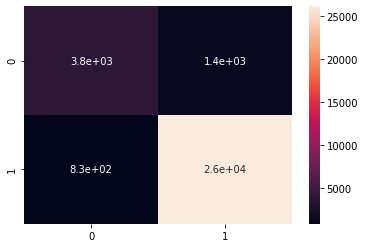

In [29]:
y_predict_train = NB_classifier.predict(X_train_vectorized)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
print(cm)
sns.heatmap(cm, annot=True)

##### Observations: You can see that model predicted fairly very well but made some misclassification which it wrongly predicted 1421 negative reviews as positive  and 829 positive reviews as negative

###### Getting accuracy score for training data 

In [30]:
accuracy_score(y_train, y_predict_train)

0.9302303947409222

##### Observations: Accuracy is 93 % meaning for every 100 records it correctly predicts 93 

###### Now Testing for test data
###### Similarly using only transform method on test data because we already fitted CountVectorizer on Training data

In [31]:
vect_test = vect.transform(X_test)
vect_test

<13822x33529 sparse matrix of type '<class 'numpy.int64'>'
	with 444360 stored elements in Compressed Sparse Row format>

In [32]:
vect_test.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

###### Applying Multinomial Naive Bayes Classifier

In [33]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(vect_test, y_test)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

##### Confusion Matrix

In [34]:
from sklearn.metrics import accuracy_score,confusion_matrix

[[ 1337   985]
 [   69 11431]]


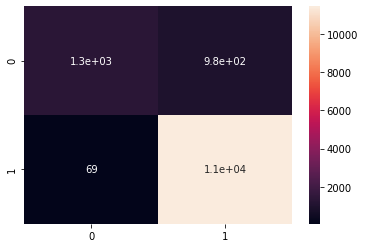

In [35]:
y_predict_test = NB_classifier.predict(vect_test)
y_predict_test
cm = confusion_matrix(y_test, y_predict_test)
print(cm)
sns.heatmap(cm, annot=True)

##### Observations: Model predicts fairly well on test data but again it incorrectly predicts 985 negative reviews as positive reviews.

###### Accuracy score on test data

In [36]:
accuracy_score(y_test, y_predict_test)

0.9237447547388221

#### Observations: Accuracy score on test data is 92 % meaning that it predicts every 92 records correctly for every 100 records.

###### IMPROVING THE MODEL

###### USING RANDOMIZED SEARCH CV to get best parameters for Multinominal Naive Bayes .

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand # a uniform random variable ranging from 0 to 1 because alpha parameter in Naive Bayes has value range from 0 to 1. 
alp=MultinomialNB()
nb_params={'alpha':sp_rand()}

#### Creating a hyperparameter tuning function to get best parameter value for alpha 

In [38]:
def hyperparameter_tuning(alp,nb_params,iters):
    rsearch=RandomizedSearchCV(alp,param_distributions=nb_params,n_iter=iters)
    rsearch.fit(vect_test,y_test) # applying RandomizedSearchCV on test data
    ht_params=rsearch.best_params_  # getting best value for alpha parameter
    ht_score=rsearch.best_score_  # getting score for RandomziedSearchCV
    return ht_params,ht_score
nb_parameters, nb_ht_score=hyperparameter_tuning(alp,nb_params,40)

###### Getting best parameter values


In [39]:
nb_parameters

{'alpha': 0.17080167351554298}

##### You can observe that alpha parameter value is 0.17

##### Getting the score for RandomizedSearchCV 

In [40]:
nb_ht_score

0.8952399358321796

###### Score is 89

###### Confusion Matrix

[[ 1935   387]
 [  256 11244]]


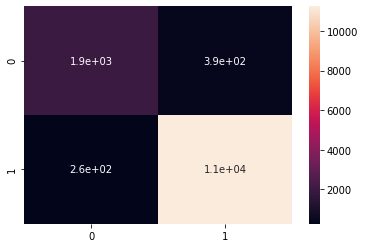

In [41]:
NB_classifier = MultinomialNB(alpha=0.17)
NB_classifier.fit(vect_test, y_test)
y_predict_test = NB_classifier.predict(vect_test)
y_predict_test
cm = confusion_matrix(y_test, y_predict_test)
print(cm)
sns.heatmap(cm, annot=True)

##### Observations: Model after using hyperparameter tuning gives fairly well predictions but again model misclassifies 387 positive reviews as negative and 256 negative reviews as positive reviews.

###### Getting Accuracy Score

In [42]:
accuracy_score(y_test, y_predict_test)

0.9534799594848792

###### Observations: Accuracy Score is almost 95 % meaning 95 records for every 100 are correctly classified which improved the model accuracy  by 3%.

#### Checking the model on random review 

In [43]:
testing_sample = ['amazing food! highly recommmended']
testing_sample_countvectorizer = vect.transform(testing_sample)
test_predict = NB_classifier.predict(testing_sample_countvectorizer)
test_predict

array([1], dtype=int64)

##### Observations: Model correctly predicts random review as positive.

###### Another random review testing on model.

In [44]:
testing_sample1 = ['shit food bad unpleasant vomitting made me sick worse']
testing_sample_countvectorizer1 = vect.transform(testing_sample1)
test_predict = NB_classifier.predict(testing_sample_countvectorizer1)
test_predict

array([0], dtype=int64)

##### Observations: Model correctly predicts random review as negative

# TFIDF (TERM FREQUENCY INVERSE DOCUMENT FREQUENCY)

<center>
<img src="ipynb.images/TFIDF.png" width=500 />
</center>

#### Applying TFIDF Vectorizer to convert raw test review into TFIDF matrix features.
### TF : Term Frequency is count of words in document 
#### IDF : Inverse Document Frequency is Total no. of records of text reviews/ Frequency of word appearing in total of whole text reviews
#### TFIDF= TF*IDF

###### Here Using TFIDF Vectorizer where considering single word, combination of 2 words , combination of 3 words and combination of 4 words each as single entry as columns.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,4), min_df=10)
X_Train_TFIDF=tfidf.fit_transform(X_train)
print(X_Train_TFIDF.shape)

(32249, 20467)


##### Suggesting 32249 records of reviews are in training test and 20467 combination of unique words are columns.

##### Applying Multinomial Naive Bayes Classifier on training data

In [46]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_Train_TFIDF, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
from sklearn.metrics import accuracy_score,confusion_matrix

### Confusion Matrix

[[ 2005  3265]
 [   69 26910]]


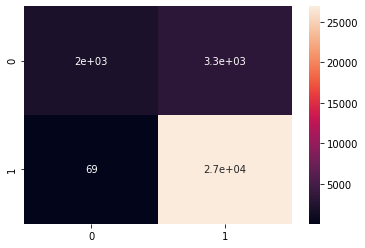

In [48]:
y_predict_train = NB_classifier.predict(X_Train_TFIDF)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
print(cm)
sns.heatmap(cm, annot=True)

##### Observations: Model does average job it has some errors classifying negative reviews.

##### Accuracy Score

In [49]:
accuracy_score(y_train, y_predict_train)

0.8966169493627709

#### Observations: Model Accuracy Score is 89 % .

###### Trying on Test data using only transform method because Tfidf Vectorizer is already fitted on Training data

In [50]:
tfidf_test = tfidf.transform(X_test)
tfidf_test

<13822x20467 sparse matrix of type '<class 'numpy.float64'>'
	with 569517 stored elements in Compressed Sparse Row format>

#### Multinomial Naive Bayes Classifier 

In [51]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(tfidf_test, y_test)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [52]:
from sklearn.metrics import accuracy_score,confusion_matrix

###### Confusion Matrix

[[  329  1993]
 [    4 11496]]


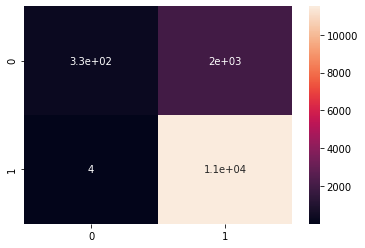

In [53]:
y_predict_test = NB_classifier.predict(tfidf_test)
y_predict_test
cm = confusion_matrix(y_test, y_predict_test)
print(cm)
sns.heatmap(cm, annot=True)

#### Observations: Model does good job but does some blunder in classifying negative reviews and it misclassifies it as positive.

##### Accuracy Score

In [54]:
accuracy_score(y_test, y_predict_test)

0.8555201852119809

#### Observations: Accuarcy is 85 %

#### Improving the model using RandomziedSearchCV to get best parameters

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand # a uniform random variable ranging from 0 to 1 because alpha parameter in Naive Bayes has value range 
alp=MultinomialNB()
nb_params={'alpha':sp_rand()}

In [56]:
def hyperparameter_tuning(alp,nb_params,iters):
    rsearch=RandomizedSearchCV(alp,param_distributions=nb_params,n_iter=iters)
    rsearch.fit(tfidf_test,y_test) # applying RandomizedSearchCV on test data
    ht_params=rsearch.best_params_ # getting best value for alpha parameter
    ht_score=rsearch.best_score_   # getting score for RandomziedSearchCV
    return ht_params,ht_score
nb_parameters, nb_ht_score=hyperparameter_tuning(alp,nb_params,40)

In [57]:
nb_parameters

{'alpha': 0.06688541813714888}

In [58]:
nb_ht_score

0.8982064152118558

[[ 1814   508]
 [   49 11451]]


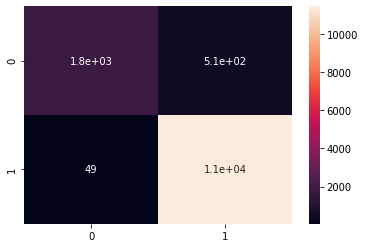

In [59]:
NB_classifier = MultinomialNB(alpha=0.066)
NB_classifier.fit(tfidf_test, y_test)
y_predict_test = NB_classifier.predict(tfidf_test)
y_predict_test
cm = confusion_matrix(y_test, y_predict_test)
print(cm)
sns.heatmap(cm, annot=True)

##### Observations: Model prediction is good but does some error in misclassifying negative reviews as positive

###### Accuracy Score

In [60]:
accuracy_score(y_test, y_predict_test)

0.959701924468239

##### Observations: Accuracy is 95% and by using hyperparameter it improved the model accuracy by 10 % 

#### Random review for testing

In [61]:
testing_sample = ['amazing food! highly recommmended']
testing_sample_countvectorizer = tfidf.transform(testing_sample)
test_predict = NB_classifier.predict(testing_sample_countvectorizer)
test_predict

array([1], dtype=int64)

#### Observations: Model predicts random review sample correctly as positive

In [62]:
testing_sample1 = ['shit food bad unpleasant vomitting made me sick worse']
testing_sample_countvectorizer1 = tfidf.transform(testing_sample1)
test_predict = NB_classifier.predict(testing_sample_countvectorizer1)
test_predict

array([0], dtype=int64)

#### Observations: Model predicts random review sample correctly as negative

##### Conclusion:
<br><b>1.Both Model did very good job almost same accuracy after using HyperParameter Tuning technique.</b></br>
<br><b> 2.Also tested the model on random txet reviews and both models predited correctly for all random sample reviews.</b></br>